## 随机森林 Random Forests

<img src="data/logo.png" alt="Drawing" style="width: 300px;"/>

本项目中，我们将探索决策树并且拓展到随机森林。
和我们之前见过的线性和逻辑回归不同，这种模型没有权重，但是有很好的可解释性。

## 概述

<img src="data/dtree.jpg" alt="Drawing" style="width: 300px;"/>

* **目标:** 给定一些数据, 根据选择的特征来判断状态并分开数据，并做出预测。
* **优点:**
	* 决策树可以用作分类树或回归树
	* 高可解释性
	* 并不需要特别复杂的数据预处理
* **缺点:**
	* 当训练数据少于分类类别的时候表现很差
* **其它**
	* 一组决策树可以组成一个随机森林。届时预测结果由所有决策树共同决定。

## 训练
我们来看看之前的决策树例子，这个决策树用来判断今天的气候能不能让我们出门愉快玩耍。
数据有三个特征, 天气(outlook), 湿度(humidity) 和有没有有风(wind)，结果是二分类的 yes 和 no

*步骤* : 
1. 基于特征切分数据集。(例如仅仅根据三个特征判断是不是出去玩)
2. 计算特征分裂时的损失。常用的算法，比如使用Gini系数来计算的**CART**，还有使用熵和信息增益来计算的 **ID3**，基本都计算了预测值中的杂质或者无序性。可以查看 [这篇文章](https://medium.com/deep-math-machine-learning-ai/chapter-4-decision-trees-algorithms-b93975f7a1f1) 学习如何计算 **信息增益**。
  * ~$H(X) = \sum_{c \in C} -p(c) log_2p(c)~$
  * 其中:
      * H(X): 数据集 X 的熵
      * C: 类别
      * p(c): 在c类别中的示例在所有实例中的占比
  
在二分类任务中，当所有的样例在一个类别下都是相同的，那么它的熵值为0，如果只有一半是正确的，那么它的熵值则为1（最差的情况）。决定了熵值后，需要计算出 信息增益(IG)(例如在当数据X基于特征F分裂后，不确定性减少了多少)。
  
  * ~$IG(F, X) = H(S) - \sum_{t\in T}p(t)H(t)~$
  * 其中:
      * IG(F. X): 数据X基于特征F分裂后的信息增益
      * H(X): 数据集X的熵
      * T: 基于分裂F后的子集
      * p(t): 在t类别中的示例在所有实例中的占比
      * H(t): 子集t的熵
      
	**注意:** 回归问题中，可以用 **标准差(standard deviation)** 替代信息增益
3. 进行完所有的特征分裂后，信息增益最高的分裂将作为第一次特征分裂(就是决策树的根).
4. 第一次分裂后，余下的所有特征中重复上一部操作。最后我们将得到叶结点，叶结点中我们期望大部分样本来自同一类。

## 数据
继续使用 Titanic 数据

In [1]:
from argparse import Namespace
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import urllib

In [2]:
# 参数
args = Namespace(
    seed=1234,
    data_file="data/titanic.csv",
    train_size=0.75,
    test_size=0.25,
    num_epochs=100,
    max_depth=4,
    min_samples_leaf=5,
    n_estimators=10, # of trees in the forest
)

# 设置随机种子来保证结果可复现
np.random.seed(args.seed)

In [3]:
# 将数据读取进dataframe
df = pd.read_csv(args.data_file, header=0)
df.head()

,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,survived
0,1,"Allen, Miss. Elisabeth Walton",female,29.0000,0,0,24160,211.3375,B5,S,1
1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.5500,C22 C26,S,1
2,1,"Allison, Miss. Helen Loraine",female,2.0000,1,2,113781,151.5500,C22 C26,S,0
3,1,"Allison, Mr. Hudson Joshua Creighton",male,30.0000,1,2,113781,151.5500,C22 C26,S,0
4,1,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.0000,1,2,113781,151.5500,C22 C26,S,0


## 使用 Scikit-learn 实现

In [4]:
from sklearn.tree import DecisionTreeClassifier

In [5]:
# 预处理
def preprocess(df):
  
    # 去掉有NaN值的行
    df = df.dropna()

    # 去掉含有文本的列(我们将在以后学习如何处理他们)
    features_to_drop = ["name", "cabin", "ticket"]
    df = df.drop(features_to_drop, axis=1)

    # pclass, sex 和 embarked 是类别变量
    # 把字符串转化成浮点数
    df['sex'] = df['sex'].map( {'female': 0, 'male': 1} ).astype(int)
    df["embarked"] = df['embarked'].dropna().map( {'S':0, 'C':1, 'Q':2} ).astype(int)

    return df

In [6]:
# 进行预处理
df = preprocess(df)
df.head()

,pclass,sex,age,sibsp,parch,fare,embarked,survived
0,1,0,29.0000,0,0,211.3375,0,1
1,1,1,0.9167,1,2,151.5500,0,1
2,1,0,2.0000,1,2,151.5500,0,0
3,1,1,30.0000,1,2,151.5500,0,0
4,1,0,25.0000,1,2,151.5500,0,0


In [7]:
# 拆分数据集
mask = np.random.rand(len(df)) < args.train_size
train_df = df[mask]
test_df = df[~mask]
print ("Train size: {0}, test size: {1}".format(len(train_df), len(test_df)))

Train size: 199, test size: 71


In [8]:
# 分离 X 和 y
X_train = train_df.drop(["survived"], axis=1)
y_train = train_df["survived"]
X_test = test_df.drop(["survived"], axis=1)
y_test = test_df["survived"]

**注意:** 你可以改变 `max_depth` 和 `min_samples` 来观察决策树的表现。
如何知道停止分裂的时间点呢？当有许多特征的时候，决策树会变得非常庞大，有时继续分裂会导致过拟合。
下面有几种常用处理办法:
* 设置在叶节点中的最少样本个数。
* 设置最大深度(从树根到叶节点的最大距离)。
* 删除几乎没有信息增益的特征(我们称为剪枝)。

In [9]:
# 初始化模型
dtree = DecisionTreeClassifier(criterion="entropy", random_state=args.seed, 
                               max_depth=args.max_depth, 
                               min_samples_leaf=args.min_samples_leaf)

In [10]:
# 训练
dtree.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=4,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=1234,
            splitter='best')

In [11]:
# 预测
pred_train = dtree.predict(X_train)
pred_test = dtree.predict(X_test)

## 评估

In [12]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

In [13]:
# 准确率
train_acc = accuracy_score(y_train, pred_train)
test_acc = accuracy_score(y_test, pred_test)
print ("train acc: {0:.2f}, test acc: {1:.2f}".format(train_acc, test_acc))

train acc: 0.82, test acc: 0.70


In [14]:
# 计算其他的模型评估指标
precision, recall, F1, _ = precision_recall_fscore_support(y_test, pred_test, average="binary")
print ("precision: {0:.2f}. recall: {1:.2f}, F1: {2:.2f}".format(precision, recall, F1))

precision: 0.70. recall: 0.79, F1: 0.75


## 可解释性

In [15]:
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus

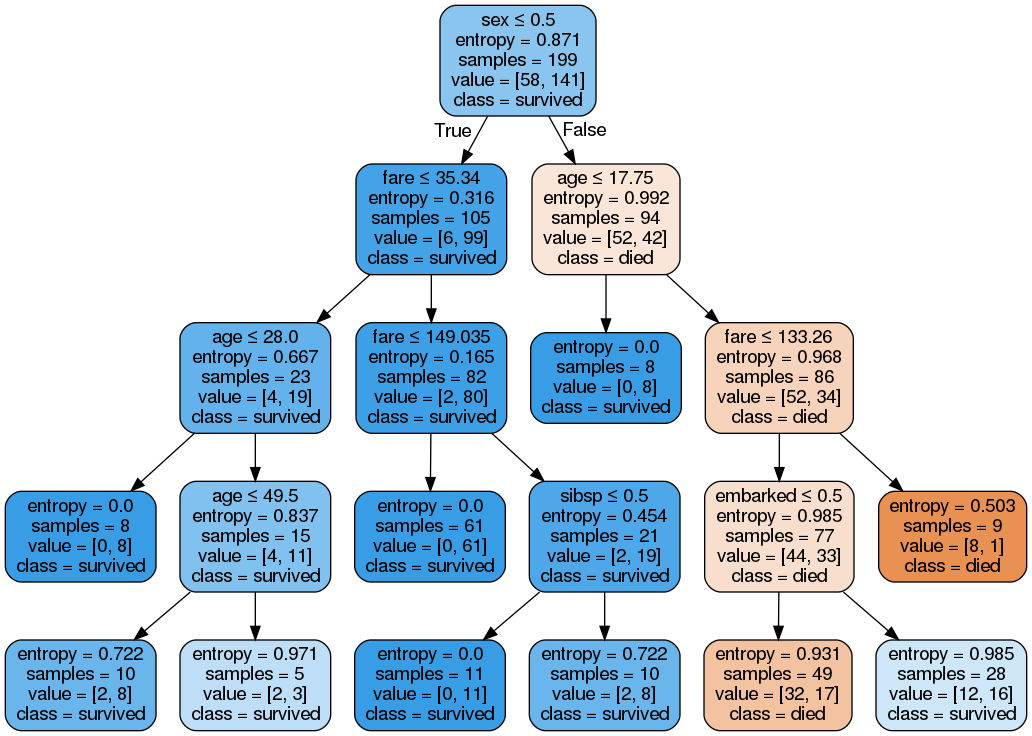

In [16]:
# 可解释性
dot_data = StringIO()
export_graphviz(dtree, out_file=dot_data, 
                feature_names=list(train_df.drop(['survived'], axis=1)), 
                class_names = ['died', 'survived'],
                rounded = True, filled= True, special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png(), width=500, height=300)

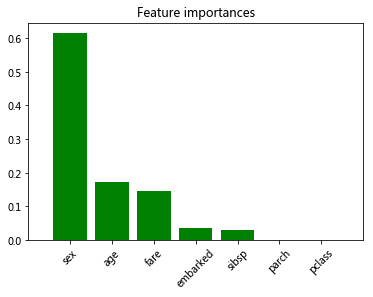

sex - 0.615
age - 0.174
fare - 0.147
embarked - 0.035
sibsp - 0.030
parch - 0.000
pclass - 0.000


In [17]:
# 特征重要性
features = list(X_test.columns)
importances = dtree.feature_importances_
indices = np.argsort(importances)[::-1]
num_features = len(importances)

# 画出特征重要性
plt.figure()
plt.title("Feature importances")
plt.bar(range(num_features), importances[indices], color="g", align="center")
plt.xticks(range(num_features), [features[i] for i in indices], rotation='45')
plt.xlim([-1, num_features])
plt.show()

# 打印值
for i in indices:
    print ("{0} - {1:.3f}".format(features[i], importances[i]))

## 随机森林

一组决策树可以组成一片随机森林。一组不同的树将比单个决策树产生更准确的预测。 
但是如果我们在同样的数据下使用同样的分裂条件，又该如何保证每棵树是不同的呢？一个解决方法是让不同的数据子集组成不同的树，甚至使用不同的特征阈值。

<img src="data/forest.png" alt="Drawing" style="width: 500px;"/>

## 使用 Scikit-learn 实现

In [18]:
from sklearn.ensemble import RandomForestClassifier

In [19]:
# 初始化随机森林
forest = RandomForestClassifier(
    n_estimators=args.n_estimators, criterion="entropy", 
    max_depth=args.max_depth, min_samples_leaf=args.min_samples_leaf)

In [20]:
# 训练
forest.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=4, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [21]:
# 预测
pred_train = forest.predict(X_train)
pred_test = forest.predict(X_test)

In [22]:
# 准确率
train_acc = accuracy_score(y_train, pred_train)
test_acc = accuracy_score(y_test, pred_test)
print ("train acc: {0:.2f}, test acc: {1:.2f}".format(train_acc, test_acc))

# 计算其它模型评估指标
precision, recall, F1, _ = precision_recall_fscore_support(y_test, pred_test, average="binary")
print ("precision: {0:.2f}. recall: {1:.2f}, F1: {2:.2f}".format(precision, recall, F1))

train acc: 0.80, test acc: 0.68
precision: 0.65. recall: 0.87, F1: 0.75


## 可解释性

查看随机森林并获得特征重要性也很容易

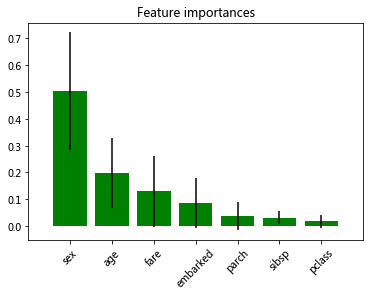

sex - 0.503
age - 0.198
fare - 0.129
embarked - 0.086
parch - 0.037
sibsp - 0.031
pclass - 0.017


In [23]:
# 特征重要性
features = list(X_test.columns)
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
indices = np.argsort(importances)[::-1]
num_features = len(importances)

# 画出特征重要性
plt.figure()
plt.title("Feature importances")
plt.bar(range(num_features), importances[indices], yerr=std[indices], 
        color="g", align="center")
plt.xticks(range(num_features), [features[i] for i in indices], rotation='45')
plt.xlim([-1, num_features])
plt.show()

# 打印值
for i in indices:
    print ("{0} - {1:.3f}".format(features[i], importances[i]))

## 网格搜索

在训练好的随机森林模型中中，我使用了许多超参数 (criterion, max_depth等等), 在以后的课程中我们将学习的模型会有更多的超参数。
那么应该怎样选择值呢？一般来说，必须根据在验证集上的性能来结果调整它们。Scikit-learn 提供了可以进行无遗漏网格搜索的函数方便我们调整超参数。

In [24]:
from sklearn.model_selection import GridSearchCV

In [25]:
# 创建网格参数 
param_grid = {
    'bootstrap': [True],
    'max_depth': [10, 20, 50],
    'max_features': [len(features)],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [4, 8],
    'n_estimators': [5, 10, 50] # of trees
}

In [26]:
# 初始化随机森林
forest = RandomForestClassifier()

In [27]:
# 实例化网格搜索
grid_search = GridSearchCV(estimator=forest, param_grid=param_grid, cv=3, 
                           n_jobs=-1, verbose=1)

In [28]:
# 网格搜索拟合数据
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 54 candidates, totalling 162 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 162 out of 162 | elapsed:    2.9s finished
/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'bootstrap': [True], 'max_depth': [10, 20, 50], 'max_features': [7], 'min_samples_leaf': [3, 4, 5], 'min_samples_split': [4, 8], 'n_estimators': [5, 10, 50]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=1)

In [29]:
# 查看最佳参数
grid_search.best_params_

{'bootstrap': True,
 'max_depth': 10,
 'max_features': 7,
 'min_samples_leaf': 3,
 'min_samples_split': 8,
 'n_estimators': 5}

In [30]:
# 使用最佳参数训练
best_forest = grid_search.best_estimator_
best_forest.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features=7, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=3, min_samples_split=8,
            min_weight_fraction_leaf=0.0, n_estimators=5, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [31]:
# 预测
pred_train = best_forest.predict(X_train)
pred_test = best_forest.predict(X_test)

In [32]:
# 准确率
train_acc = accuracy_score(y_train, pred_train)
test_acc = accuracy_score(y_test, pred_test)
print ("train acc: {0:.2f}, test acc: {1:.2f}".format(train_acc, test_acc))

# 计算其它模型评估值标 
precision, recall, F1, _ = precision_recall_fscore_support(y_test, pred_test, average="binary")
print ("precision: {0:.2f}. recall: {1:.2f}, F1: {2:.2f}".format(precision, recall, F1))

train acc: 0.89, test acc: 0.73
precision: 0.73. recall: 0.82, F1: 0.77
